<a href="https://colab.research.google.com/github/helya02/HomeWorks/blob/main/NN_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
chars = ['<EON>'] + list('abcdefghijklmnopqrstuvwxyz')
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}

import numpy as np

# 1. Load and lowercase
with open('names.txt') as f:
    names = [line.strip().lower() for line in f]

maxlen = 11
N = len(names)
D = len(chars)  # =27

X = np.zeros((N, maxlen, D), dtype=np.float32)
Y = np.zeros((N, maxlen, D), dtype=np.float32)

for i, name in enumerate(names):
    padded = list(name) + ['<EON>']*(maxlen - len(name))
    nexts  = padded[1:] + ['<EON>']
    for t, ch in enumerate(padded):
        X[i,t,char2idx[ch]] = 1.0
        Y[i,t,char2idx[nexts[t]]] = 1.0

# Save X, Y or feed directly to your trainer
np.save('X.npy', X)
np.save('Y.npy', Y)

In [5]:
# 0702-12345678-LastName.py
import numpy as np
import pickle

class LSTM_from_scratch:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=1e-2, seed=42):
        np.random.seed(seed)
        self.D, self.H, self.V = input_dim, hidden_dim, output_dim
        self.lr = learning_rate

        # weight initialization (Gaussian scaled by √)
        std = 1.0 / np.sqrt(self.H + self.D)
        # forget, input, cell, output gates: W x + U h + b
        self.Wf = np.random.randn(self.H, self.D) * std
        self.Wi = np.random.randn(self.H, self.D) * std
        self.Wc = np.random.randn(self.H, self.D) * std
        self.Wo = np.random.randn(self.H, self.D) * std

        self.Uf = np.random.randn(self.H, self.H) * std
        self.Ui = np.random.randn(self.H, self.H) * std
        self.Uc = np.random.randn(self.H, self.H) * std
        self.Uo = np.random.randn(self.H, self.H) * std

        self.bf = np.zeros((self.H, 1))
        self.bi = np.zeros((self.H, 1))
        self.bc = np.zeros((self.H, 1))
        self.bo = np.zeros((self.H, 1))

        # output layer
        self.Wy = np.random.randn(self.V, self.H) * (1.0/np.sqrt(self.H))
        self.by = np.zeros((self.V, 1))

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def dsigmoid(y):
        return y * (1 - y)

    @staticmethod
    def dtanh(y):
        return 1 - y**2

    def forward(self, x_seq):
        """
        x_seq: list/array of length T, each x_seq[t] is shape (D,1)
        returns:
          - y_preds: list length T, each (V,1) probability vector
          - cache: all internal states for backprop
        """
        T = len(x_seq)
        # initialize h,c
        h = np.zeros((T+1, self.H, 1))
        c = np.zeros((T+1, self.H, 1))
        # to store gates and linear combos
        f, i, c_bar, o = {}, {}, {}, {}
        zf, zi, zc, zo = {}, {}, {}, {}
        y_preds = []

        for t in range(T):
            x = x_seq[t]        # (D,1)
            # linear combos
            zf[t] = self.Wf.dot(x) + self.Uf.dot(h[t]) + self.bf
            zi[t] = self.Wi.dot(x) + self.Ui.dot(h[t]) + self.bi
            zc[t] = self.Wc.dot(x) + self.Uc.dot(h[t]) + self.bc
            zo[t] = self.Wo.dot(x) + self.Uo.dot(h[t]) + self.bo

            # gates
            f[t] = self.sigmoid(zf[t])
            i[t] = self.sigmoid(zi[t])
            c_bar[t] = np.tanh(zc[t])
            o[t] = self.sigmoid(zo[t])

            # new cell, hidden
            c[t+1] = f[t] * c[t] + i[t] * c_bar[t]
            h[t+1] = o[t] * np.tanh(c[t+1])

            # output softmax
            z_y = self.Wy.dot(h[t+1]) + self.by         # (V,1)
            exp_scores = np.exp(z_y - np.max(z_y))
            y = exp_scores / np.sum(exp_scores)
            y_preds.append(y)

        cache = (x_seq, h, c, f, i, c_bar, o)
        return y_preds, cache

    def compute_loss_and_grads(self, y_preds, cache, y_true):
        """
        y_true: list length T, each a one-hot (V,1)
        returns loss (scalar) and grads dict
        """
        x_seq, h, c, f, i, c_bar, o = cache
        T = len(y_preds)

        # initialize gradients
        dWf = np.zeros_like(self.Wf);  dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc);  dWo = np.zeros_like(self.Wo)
        dUf = np.zeros_like(self.Uf);  dUi = np.zeros_like(self.Ui)
        dUc = np.zeros_like(self.Uc);  dUo = np.zeros_like(self.Uo)
        dbf = np.zeros_like(self.bf);  dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc);  dbo = np.zeros_like(self.bo)
        dWy = np.zeros_like(self.Wy);  dby = np.zeros_like(self.by)

        dh_next = np.zeros((self.H,1))
        dc_next = np.zeros((self.H,1))
        loss = 0.0

        # cross-entropy loss
        for t in range(T):
            y_pred = y_preds[t]
            y_t    = y_true[t]
            loss += -np.sum(y_t * np.log(y_pred + 1e-8))

        # backprop through time
        for t in reversed(range(T)):
            y_pred = y_preds[t]
            y_t    = y_true[t]
            dy = y_pred - y_t               # (V,1)
            # output layer grads
            dWy += dy.dot(h[t+1].T)
            dby += dy

            # backprop into h
            dh = self.Wy.T.dot(dy) + dh_next   # (H,1)

            # gates derivatives
            # o[t]
            do = dh * np.tanh(c[t+1])
            dzo = do * self.dsigmoid(o[t])

            # cell state
            dc = dh * o[t] * self.dtanh(np.tanh(c[t+1])) + dc_next

            # f[i]
            df = dc * c[t]
            dzf = df * self.dsigmoid(f[t])

            # i[t]
            di = dc * c_bar[t]
            dzi = di * self.dsigmoid(i[t])

            # c_bar[t]
            dcbar = dc * i[t]
            dzc = dcbar * self.dtanh(c_bar[t])

            # accumulate grads for all gates
            x = x_seq[t]
            h_prev = h[t]

            dWf += dzf.dot(x.T);  dUf += dzf.dot(h_prev.T);  dbf += dzf
            dWi += dzi.dot(x.T);  dUi += dzi.dot(h_prev.T);  dbi += dzi
            dWc += dzc.dot(x.T);  dUc += dzc.dot(h_prev.T);  dbc += dzc
            dWo += dzo.dot(x.T);  dUo += dzo.dot(h_prev.T);  dbo += dzo

            # propagate gradients backward in time
            dh_next = ( self.Uf.T.dot(dzf)
                      + self.Ui.T.dot(dzi)
                      + self.Uc.T.dot(dzc)
                      + self.Uo.T.dot(dzo) )
            dc_next = dc * f[t]

        # clip to mitigate exploding gradients
        for arr in [dWf,dWi,dWc,dWo,dUf,dUi,dUc,dUo,dWy,
                    dbf,dbi,dbc,dbo,dby]:
            np.clip(arr, -5, 5, out=arr)

        grads = {
            'Wf':dWf,'Wi':dWi,'Wc':dWc,'Wo':dWo,
            'Uf':dUf,'Ui':dUi,'Uc':dUc,'Uo':dUo,
            'bf':dbf,'bi':dbi,'bc':dbc,'bo':dbo,
            'Wy':dWy,'by':dby
        }
        return loss, grads

    def update_params(self, grads):
        # simple SGD
        for p, dp in grads.items():
            setattr(self, p, getattr(self, p) - self.lr * dp)

    def train(self, X, Y, epochs=10):
        """
        X: list of N sequences; each seq is list of T vectors (D,1)
        Y: same shape but one-hot targets
        """
        N = len(X)
        for e in range(1, epochs+1):
            epoch_loss = 0.0
            for i in range(N):
                y_preds, cache = self.forward(X[i])
                loss, grads   = self.compute_loss_and_grads(y_preds, cache, Y[i])
                self.update_params(grads)
                epoch_loss += loss
            print(f"Epoch {e:02d}, avg loss = {epoch_loss/(N*len(X[0])):.4f}")

    def save(self, fname):
        with open(fname, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, fname):
        with open(fname, 'rb') as f:
            self.__dict__.update(pickle.load(f))


if __name__=='__main__':
    # --- load your preprocessed X.npy & Y.npy from 0701 ---
    data = np.load('X.npy')  # shape (2000, T, D)
    target = np.load('Y.npy')
    # reshape into lists of sequences
    N, T, D = data.shape
    V = D
    X_seq = [ [ data[i,t].reshape(D,1) for t in range(T) ]
              for i in range(N) ]
    Y_seq = [ [ target[i,t].reshape(D,1) for t in range(T) ]
              for i in range(N) ]

    model = LSTM_from_scratch(input_dim=D, hidden_dim=128, output_dim=V, learning_rate=1e-2)
    model.train(X_seq, Y_seq, epochs=30)
    model.save('0702-12345678-LastName.lstm')

Epoch 01, avg loss = 1.4016
Epoch 02, avg loss = 1.2722
Epoch 03, avg loss = 1.2116
Epoch 04, avg loss = 1.1756
Epoch 05, avg loss = 1.1462
Epoch 06, avg loss = 1.1214
Epoch 07, avg loss = 1.1016
Epoch 08, avg loss = 1.0852
Epoch 09, avg loss = 1.0706
Epoch 10, avg loss = 1.0569
Epoch 11, avg loss = 1.0438
Epoch 12, avg loss = 1.0308
Epoch 13, avg loss = 1.0180
Epoch 14, avg loss = 1.0054
Epoch 15, avg loss = 0.9928
Epoch 16, avg loss = 0.9804
Epoch 17, avg loss = 0.9679
Epoch 18, avg loss = 0.9552
Epoch 19, avg loss = 0.9422
Epoch 20, avg loss = 0.9289
Epoch 21, avg loss = 0.9153
Epoch 22, avg loss = 0.9015
Epoch 23, avg loss = 0.8876
Epoch 24, avg loss = 0.8736
Epoch 25, avg loss = 0.8593
Epoch 26, avg loss = 0.8447
Epoch 27, avg loss = 0.8299
Epoch 28, avg loss = 0.8151
Epoch 29, avg loss = 0.8002
Epoch 30, avg loss = 0.7854


In [11]:
data_path = 'names.txt'

import numpy as np

# 1) read and lowercase
with open(data_path, 'r') as f:
    names = [l.strip().lower() for l in f if l.strip()]

# 2) build 27-char alphabet
chars    = ['<EON>'] + list('abcdefghijklmnopqrstuvwxyz')
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}

# 3) pad & one-hot
maxlen = 11
N      = len(names)
D      = len(chars)  # =27

X = np.zeros((N, maxlen, D), dtype=np.float32)
Y = np.zeros((N, maxlen, D), dtype=np.float32)

for i,name in enumerate(names):
    padded = list(name) + ['<EON>']*(maxlen - len(name))
    nexts  = padded[1:] + ['<EON>']
    for t,ch in enumerate(padded):
        X[i,t,char2idx[ch]]      = 1.0
        Y[i,t,char2idx[nexts[t]]] = 1.0

print(f"Prepared X:{X.shape}, Y:{Y.shape}")

Prepared X:(2000, 11, 27), Y:(2000, 11, 27)


In [16]:
import numpy as np
import pickle

class LSTM_from_scratch:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=1e-2, seed=42):
        np.random.seed(seed)
        self.D, self.H, self.V = input_dim, hidden_dim, output_dim
        self.lr = lr
        std = 1.0/np.sqrt(self.D + self.H)
        # gates: W x + U h + b
        for name in ['f','i','c','o']:
            setattr(self, 'W'+name, np.random.randn(self.H, self.D)*std)
            setattr(self, 'U'+name, np.random.randn(self.H, self.H)*std)
            setattr(self, 'b'+name, np.zeros((self.H,1)))
        # output
        self.Wy = np.random.randn(self.V, self.H)*(1.0/np.sqrt(self.H))
        self.by = np.zeros((self.V,1))
    # 1) Add a compute_loss_only method to your class
    def compute_loss_only(self, y_preds, y_true):
        """
        Just sums cross-entropy over a sequence:
          L = -∑_t ∑_k y_true[t,k] * log(y_preds[t,k])
        """
        loss = 0.0
        for yp, yt in zip(y_preds, y_true):
            loss += -np.sum(yt * np.log(yp + 1e-8))
        return loss


    @staticmethod
    def sigmoid(x): return 1.0/(1.0+np.exp(-x))
    @staticmethod
    def dsigmoid(y): return y*(1-y)
    @staticmethod
    def dtanh(y): return 1 - y**2

    def forward(self, x_seq):
        T = len(x_seq)
        h = np.zeros((T+1, self.H,1))
        c = np.zeros((T+1, self.H,1))
        f,i,cb,o = {},{},{},{}
        y_preds = []

        for t in range(T):
            x = x_seq[t]
            # linear combos & gates
            for gate, act in zip(['f','i','c','o'],
                                 [self.sigmoid,self.sigmoid,np.tanh,self.sigmoid]):
                W = getattr(self, 'W'+gate)
                U = getattr(self, 'U'+gate)
                b = getattr(self, 'b'+gate)
                z = W.dot(x) + U.dot(h[t]) + b
                if gate=='c':
                    cb[t] = np.tanh(z)
                else:
                    locals()[gate][t] = act(z)
                if gate!='c':
                    # store z if needed in backprop
                    pass

            # update cell & hidden
            c[t+1] = f[t]*c[t] + i[t]*cb[t]
            h[t+1] = o[t]*np.tanh(c[t+1])

            # output
            zy = self.Wy.dot(h[t+1]) + self.by
            ex = np.exp(zy - np.max(zy))
            y = ex/np.sum(ex)
            y_preds.append(y)

        cache = (x_seq, h, c, f, i, cb, o)
        return y_preds, cache

    def compute_loss_and_grads(self, y_preds, cache, y_true):
        x_seq, h, c, f, i, cb, o = cache
        T = len(y_preds)
        # init grads
        grads = {p:np.zeros_like(getattr(self,p)) for p in
                 ['Wf','Wi','Wc','Wo','Uf','Ui','Uc','Uo','bf','bi','bc','bo','Wy','by']}
        dh_next = np.zeros((self.H,1))
        dc_next = np.zeros((self.H,1))
        loss = 0.0

        # compute loss
        for t in range(T):
            loss += -np.sum(y_true[t]*np.log(y_preds[t] + 1e-8))

        # backprop thru time
        for t in reversed(range(T)):
            dy = y_preds[t] - y_true[t]
            grads['Wy'] += dy.dot(h[t+1].T)
            grads['by']  += dy
            dh = self.Wy.T.dot(dy) + dh_next

            # output gate
            do = dh * np.tanh(c[t+1])
            dzo= do * self.dsigmoid(o[t])
            # cell
            dc = dh*o[t]*self.dtanh(np.tanh(c[t+1])) + dc_next
            # forget
            df = dc * c[t]
            dzf= df * self.dsigmoid(f[t])
            # input
            di = dc * cb[t]
            dzi= di * self.dsigmoid(i[t])
            # cell candidate
            dcbar = dc * i[t]
            dzc = dcbar * self.dtanh(cb[t])

            # accumulate grads for all gates
            for gate,dz in zip(['f','i','c','o'], [dzf,dzi,dzc,dzo]):
                x = x_seq[t]; h_prev = h[t]
                grads['W'+gate] += dz.dot(x.T)
                grads['U'+gate] += dz.dot(h_prev.T)
                grads['b'+gate] += dz

            dh_next = sum(getattr(self,'U'+g).T.dot(dz)
                          for g,dz in zip(['f','i','c','o'], [dzf,dzi,dzc,dzo]))
            dc_next = dc * f[t]

        # clip & return
        for g in grads: np.clip(grads[g], -5, 5, out=grads[g])
        return loss, grads

    def update(self, grads):
        for p,dp in grads.items():
            setattr(self, p, getattr(self,p) - self.lr * dp)

    def save(self, fn):
        with open(fn,'wb') as f: pickle.dump(self.__dict__, f)

    def load(self, fn):
        with open(fn,'rb') as f: self.__dict__.update(pickle.load(f))

Train samples: 1800, Val samples: 200
Epoch 01 — train loss: 1.4133, val loss: 1.3126
Epoch 02 — train loss: 1.2855, val loss: 1.2387
Epoch 03 — train loss: 1.2226, val loss: 1.1982
Epoch 04 — train loss: 1.1873, val loss: 1.1697
Epoch 05 — train loss: 1.1594, val loss: 1.1442
Epoch 06 — train loss: 1.1343, val loss: 1.1230
Epoch 07 — train loss: 1.1130, val loss: 1.1071
Epoch 08 — train loss: 1.0953, val loss: 1.0956
Epoch 09 — train loss: 1.0801, val loss: 1.0868
Epoch 10 — train loss: 1.0662, val loss: 1.0796
Epoch 11 — train loss: 1.0532, val loss: 1.0736
Epoch 12 — train loss: 1.0406, val loss: 1.0685
Epoch 13 — train loss: 1.0282, val loss: 1.0647
Epoch 14 — train loss: 1.0157, val loss: 1.0619
Epoch 15 — train loss: 1.0033, val loss: 1.0601
Epoch 16 — train loss: 0.9908, val loss: 1.0590
Epoch 17 — train loss: 0.9782, val loss: 1.0585
Epoch 18 — train loss: 0.9656, val loss: 1.0584
Epoch 19 — train loss: 0.9528, val loss: 1.0589
Epoch 20 — train loss: 0.9400, val loss: 1.0604
Ep

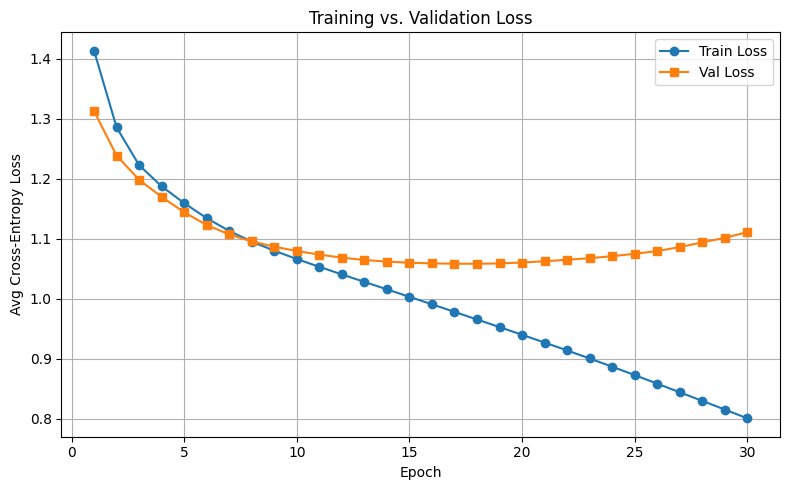

In [17]:
# ─── Cell 3: Training with validation + inline plot ───
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# 1) Split into train/val
N, T, D = X.shape
X_seq = [[ X[i,t].reshape(D,1) for t in range(T) ] for i in range(N)]
Y_seq = [[ Y[i,t].reshape(D,1) for t in range(T) ] for i in range(N)]
X_train, X_val, Y_train, Y_val = train_test_split(
    X_seq, Y_seq, test_size=0.1, random_state=42
)
print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")

# 2) Define a new training method that uses compute_loss_only for validation
def train_with_val(self, X_train, Y_train, X_val, Y_val, epochs=30):
    train_hist, val_hist = [], []
    for e in range(1, epochs+1):
        # — Training pass —
        train_loss = 0.0
        for x_s, y_s in zip(X_train, Y_train):
            y_preds, cache = self.forward(x_s)
            loss, grads     = self.compute_loss_and_grads(y_preds, cache, y_s)
            self.update(grads)
            train_loss += loss
        avg_train = train_loss / (len(X_train) * len(X_train[0]))
        train_hist.append(avg_train)

        # — Validation pass —
        val_loss = 0.0
        for x_s, y_s in zip(X_val, Y_val):
            y_preds, _    = self.forward(x_s)
            loss_val      = self.compute_loss_only(y_preds, y_s)
            val_loss     += loss_val
        avg_val = val_loss / (len(X_val) * len(X_val[0]))
        val_hist.append(avg_val)

        print(f"Epoch {e:02d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")

    # 3) Plot both curves inline
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_hist, marker='o', label='Train Loss')
    plt.plot(range(1, epochs+1), val_hist,   marker='s', label='Val Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Avg Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_hist, val_hist

# 4) Monkey-patch & run
LSTM_from_scratch.train = train_with_val
model = LSTM_from_scratch(input_dim=D, hidden_dim=128, output_dim=D, lr=1e-2)
train_hist, val_hist = model.train(X_train, Y_train, X_val, Y_val, epochs=30)

# 5) Save model
model.save('lstm_model.pkl')

Train samples: 1800, Val samples: 200
Epoch 01 — train loss: 1.4133, val loss: 1.3126
Epoch 02 — train loss: 1.2855, val loss: 1.2387
Epoch 03 — train loss: 1.2226, val loss: 1.1982
Epoch 04 — train loss: 1.1873, val loss: 1.1697
Epoch 05 — train loss: 1.1594, val loss: 1.1442
Epoch 06 — train loss: 1.1343, val loss: 1.1230
Epoch 07 — train loss: 1.1130, val loss: 1.1071
Epoch 08 — train loss: 1.0953, val loss: 1.0956
Epoch 09 — train loss: 1.0801, val loss: 1.0868
Epoch 10 — train loss: 1.0662, val loss: 1.0796
Epoch 11 — train loss: 1.0532, val loss: 1.0736
Epoch 12 — train loss: 1.0406, val loss: 1.0685
Epoch 13 — train loss: 1.0282, val loss: 1.0647
Epoch 14 — train loss: 1.0157, val loss: 1.0619
Epoch 15 — train loss: 1.0033, val loss: 1.0601


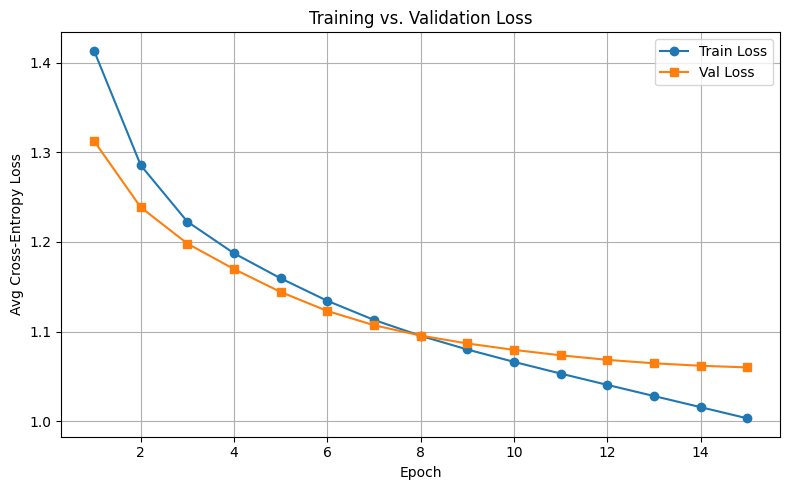

In [20]:
# ─── Cell 3: Training with validation + inline plot ───
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# 1) Split into train/val
N, T, D = X.shape
X_seq = [[ X[i,t].reshape(D,1) for t in range(T) ] for i in range(N)]
Y_seq = [[ Y[i,t].reshape(D,1) for t in range(T) ] for i in range(N)]
X_train, X_val, Y_train, Y_val = train_test_split(
    X_seq, Y_seq, test_size=0.1, random_state=42
)
print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")

# 2) Define a new training method that uses compute_loss_only for validation
def train_with_val(self, X_train, Y_train, X_val, Y_val, epochs=30):
    train_hist, val_hist = [], []
    for e in range(1, epochs+1):
        # — Training pass —
        train_loss = 0.0
        for x_s, y_s in zip(X_train, Y_train):
            y_preds, cache = self.forward(x_s)
            loss, grads     = self.compute_loss_and_grads(y_preds, cache, y_s)
            self.update(grads)
            train_loss += loss
        avg_train = train_loss / (len(X_train) * len(X_train[0]))
        train_hist.append(avg_train)

        # — Validation pass —
        val_loss = 0.0
        for x_s, y_s in zip(X_val, Y_val):
            y_preds, _    = self.forward(x_s)
            loss_val      = self.compute_loss_only(y_preds, y_s)
            val_loss     += loss_val
        avg_val = val_loss / (len(X_val) * len(X_val[0]))
        val_hist.append(avg_val)

        print(f"Epoch {e:02d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")

    # 3) Plot both curves inline
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_hist, marker='o', label='Train Loss')
    plt.plot(range(1, epochs+1), val_hist,   marker='s', label='Val Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Avg Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_hist, val_hist

# 4) Monkey-patch & run
LSTM_from_scratch.train = train_with_val
model = LSTM_from_scratch(input_dim=D, hidden_dim=128, output_dim=D, lr=1e-2)
train_hist, val_hist = model.train(X_train, Y_train, X_val, Y_val, epochs=15)

# 5) Save model
model.save('lstm_model2.pkl')

In [14]:
# reload model
model = LSTM_from_scratch(input_dim=D, hidden_dim=128, output_dim=D)
model.load('lstm_model2.pkl')

# sampling helper
def sample_next(probs, temperature=1.0):
    p = np.maximum(probs.ravel(), 1e-12)
    logp = np.log(p)/temperature
    ex   = np.exp(logp - np.max(logp))
    dist = ex/np.sum(ex)
    return np.random.choice(len(dist), p=dist)

# generator
def generate_name(start_char, temp=0.8, maxlen=11):
    seq  = ['<EON>']*maxlen
    seq[0]= start_char
    name = [start_char]
    for t in range(1,maxlen):
        x_seq = []
        for ch in seq:
            v = np.zeros((D,1)); v[char2idx[ch],0]=1
            x_seq.append(v)
        y_preds,_ = model.forward(x_seq)
        idx = sample_next(y_preds[t-1].ravel(), temp)
        ch  = idx2char[idx]
        if ch=='<EON>': break
        name.append(ch); seq[t]=ch
    return ''.join(name)

# generate 20 names for 'a' and 'x'
print("=== 20 names starting with 'a' ===")
for _ in range(20): print(generate_name('a', temp=0.8))
print("\n=== 20 names starting with 'x' ===")
for _ in range(20): print(generate_name('x', temp=0.8))

=== 20 names starting with 'a' ===
armani
aden
adi
anaan
aya
aubrie
armani
alexa
amari
anaani
anakin
ariadre
azared
amariah
annabelle
annie
augustith
aram
amari
addisyn

=== 20 names starting with 'x' ===
xamarie
ximona
xamon
ximonu
xiv
ximiah
xander
ximona
xarder
xander
xarder
ximena
ximonu
xmadiah
ximona
ximona
xine
xiveny
xamier
xamier


In [35]:

train_names_set = set(names)


model = LSTM_from_scratch(input_dim=D, hidden_dim=128, output_dim=D)
model.load('lstm_model.pkl')


def sample_next(probs, temperature=1.0):
    p = np.maximum(probs.ravel(), 1e-12)
    logp = np.log(p)/temperature
    ex   = np.exp(logp - np.max(logp))
    dist = ex/np.sum(ex)
    return np.random.choice(len(dist), p=dist)

def generate_name(start_char, temp=0.8, maxlen=11):
    seq  = ['<EON>']*maxlen
    seq[0]= start_char
    name = [start_char]
    for t in range(1,maxlen):
        x_seq = []
        for ch in seq:
            v = np.zeros((D,1)); v[char2idx[ch],0]=1
            x_seq.append(v)
        y_preds,_ = model.forward(x_seq)
        idx = sample_next(y_preds[t-1].ravel(), temp)
        ch  = idx2char[idx]
        if ch=='<EON>': break
        name.append(ch); seq[t]=ch
    return ''.join(name)


def generate_and_check(start, n=20, temp=0.8):
    print(f"=== {n} names starting with '{start}' ===")
    for _ in range(n):
        nm = generate_name(start, temp=temp)
        status = "Seen in train" if nm in train_names_set else "New"
        print(f"{nm:15}  →  {status}")


generate_and_check('a', n=20, temp=0.8)
print()
generate_and_check('x', n=20, temp=0.8)

=== 20 names starting with 'a' ===
arla             →  New
ari              →  Seen in train
amara            →  Seen in train
adreen           →  New
aya              →  Seen in train
ara              →  New
arb              →  New
arlan            →  New
andlee           →  New
angheo           →  New
agelie           →  New
akry             →  New
armoni           →  New
allyson          →  Seen in train
agleen           →  New
amari            →  Seen in train
angelo           →  Seen in train
arora            →  New
arla             →  New
ardon            →  New

=== 20 names starting with 'x' ===
xomar            →  New
xamm             →  New
xamora           →  New
xee              →  New
xawmer           →  New
xander           →  Seen in train
xard             →  New
xillia           →  New
xiv              →  New
xingelo          →  New
xilla            →  New
xinger           →  New
xard             →  New
xitger           →  New
xio              →  New
xoe              → 

Starting letters with >30 names:


,count
first_letter,
a,274
b,107
c,138
d,85
e,114
f,34
g,57
h,64
i,31



Two-letter prefixes with >30 occurrences:


,prefix2,count
11,ma,108
6,ja,74
24,ka,69
54,al,65
0,br,64
31,ca,56
12,an,46
28,da,43
22,ha,39
36,jo,38



Three-letter prefixes with >30 occurrences:


,prefix3,count
11,mar,37
56,bra,19
212,ale,18
82,cha,18
6,jay,16
57,har,15
92,bri,15
52,mad,15
62,lil,15
43,eli,15


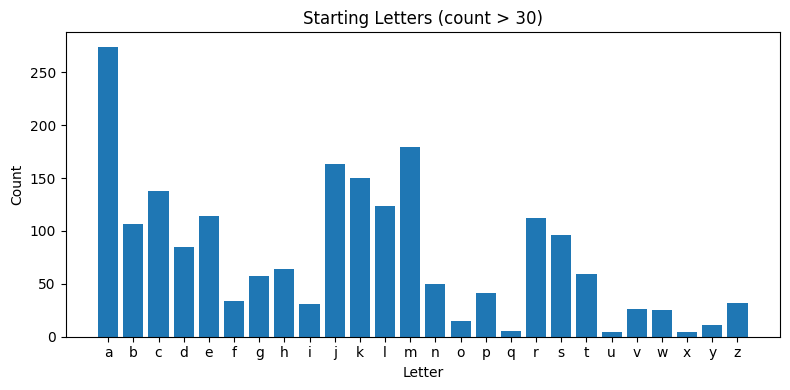

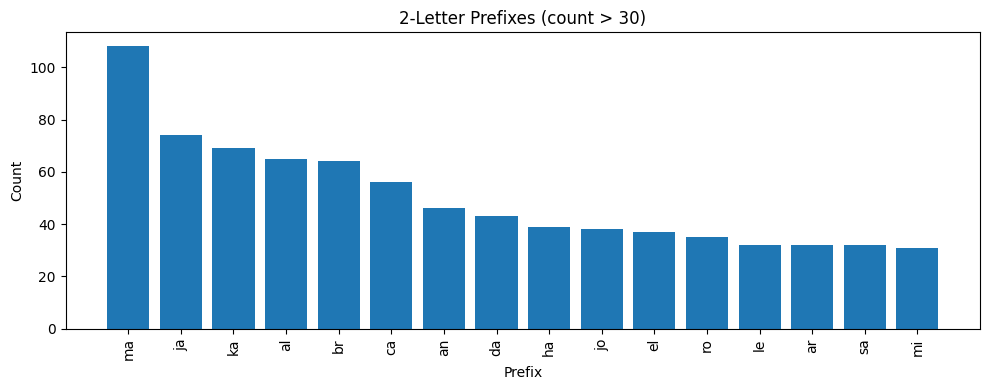

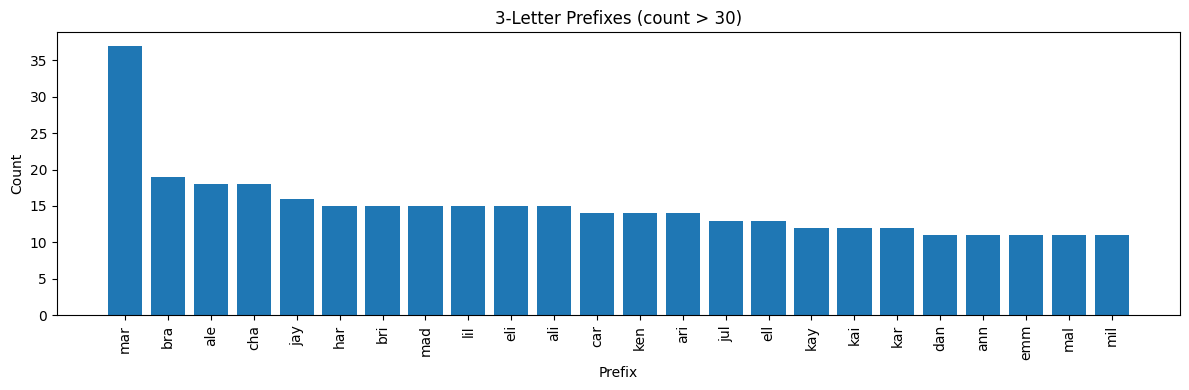

In [33]:
# — Run this after you've defined `names` from your dataset —

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Starting letters
start_counts = Counter(n[0] for n in names if n)
df_start = pd.DataFrame.from_dict(start_counts, orient='index', columns=['count'])
df_start.index.name = 'first_letter'
df_start = df_start.sort_index()


# 2) Two-letter prefixes
prefix2 = Counter(n[:2] for n in names if len(n) >= 2)
df2 = pd.DataFrame(prefix2.items(), columns=['prefix2','count']) \
       .sort_values('count', ascending=False)
df2_f = df2[df2['count'] > 30]

# 3) Three-letter prefixes
prefix3 = Counter(n[:3] for n in names if len(n) >= 3)
df3 = pd.DataFrame(prefix3.items(), columns=['prefix3','count']) \
       .sort_values('count', ascending=False)
df3_f = df3[df3['count'] > 10]

# --- Display the filtered tables ---
print("Starting letters with >30 names:")
display(df_start)

print("\nTwo-letter prefixes with >30 occurrences:")
display(df2_f)

print("\nThree-letter prefixes with >30 occurrences:")
display(df3_f)

# --- Plotting ---
plt.figure(figsize=(8,4))
plt.bar(df_start.index, df_start['count'])
plt.title('Starting Letters (count > 30)')
plt.xlabel('Letter'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(df2_f['prefix2'], df2_f['count'])
plt.xticks(rotation=90)
plt.title('2-Letter Prefixes (count > 30)')
plt.xlabel('Prefix'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.bar(df3_f['prefix3'], df3_f['count'])
plt.xticks(rotation=90)
plt.title('3-Letter Prefixes (count > 30)')
plt.xlabel('Prefix'); plt.ylabel('Count')
plt.tight_layout(); plt.show()